In [1]:
using IPG, IPG.JuMP, SCIP
using Random, LinearAlgebra, Plots

The random instance generation procedure is based on
> Dragotto, Gabriele, and Rosario Scatamacchia. “The Zero Regrets Algorithm: Optimizing over Pure Nash Equilibria via Integer Programming.” INFORMS Journal on Computing 35, no. 5 (September 2023): 1143–60. https://doi.org/10.1287/ijoc.2022.0282.

The original can be seen in their repository: https://github.com/gdragotto/ZeroRegretsAlgorithm

In [2]:
function generate_random_instance(n::Int, m::Int, lower_bound::Int, upper_bound::Int; i_type="H")
    factor = i_type == "H" ? 0.1 : 0.01
    RQ = 5

    # Generate positive semidefinite matrix M
    M = zeros(Float64, (n*m, n*m))
    while ~isposdef(M)
        M = rand(Float64, (n*m, n*m))
        M = (M .* 2 .- 1) .* RQ  # scaling
        M = M * M'
    end

    M_max = maximum(M)
    for i in 1:n
        for j in ((i-1) * m + 1):(i * m)
            for k in (i * m + 1):(size(M, 2))
                vjk = (rand() * 2 - 1) * factor * M_max
                vjk = round(vjk, digits=1)
                M[j, k] += vjk
                M[k, j] -= vjk
            end
        end
    end

    # build players
    players = Vector{Player{QuadraticPayoff}}()
    for p in 1:n
        # build payoff
        Qp = Vector{Matrix{Float64}}()
        for k in 1:n
            push!(Qp, M[((p-1) * m + 1):(p * m), ((k-1) * m + 1):(k * m)])
        end

        cp = rand(-RQ:RQ, m)
        Πp = QuadraticPayoff(cp, Qp, p)

        # build strategy space
        Xp = Model()
        @variable(Xp, lower_bound <= x[1:m] <= upper_bound, Int)

        push!(players, Player(Xp, Πp, p))
    end

    return players
end

generate_random_instance (generic function with 1 method)

In [3]:
players = generate_random_instance(2, 1, -500, 500)

# IPG.initialize_strategies = IPG.initialize_strategies_player_alone
IPG.initialize_strategies = IPG.initialize_strategies_feasibility

Σ, payoff_improvements = IPG.SGM(players, SCIP.Optimizer, max_iter=25, verbose=true)

Game initialized with strategies: [[[500.0]], [[500.0]]]
Iter 1
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy([1.0], [[500.0]]), DiscreteMixedStrategy([1.0], [[500.0]])]
Deviation found for player 2 with payoff improvement 3.9207937456142576e6
New strategy added for player 2: [-372.0000000000152]
Iter 2
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy([1.0], [[500.0]]), DiscreteMixedStrategy([1.0], [[-372.0000000000152]])]
Deviation found for player 1 with payoff improvement 167392.05454561982
New strategy added for player 1: [297.0]
Iter 3
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy([1.0], [[297.0]]), DiscreteMixedStrategy([1.0], [[-372.0000000000152]])]
Deviation found for player 2 with payoff improvement 117774.34949967443
New strategy added for player 2: [-221.0]
Iter 4
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy([1.0], [[297.0]]), DiscreteMixedStrategy([1.0], [[

(Vector{DiscreteMixedStrategy}[[DiscreteMixedStrategy([1.0], [[500.0]]), DiscreteMixedStrategy([1.0], [[500.0]])], [DiscreteMixedStrategy([1.0], [[500.0]]), DiscreteMixedStrategy([1.0], [[-372.0000000000152]])], [DiscreteMixedStrategy([1.0], [[297.0]]), DiscreteMixedStrategy([1.0], [[-372.0000000000152]])], [DiscreteMixedStrategy([1.0], [[297.0]]), DiscreteMixedStrategy([1.0], [[-221.0]])], [DiscreteMixedStrategy([1.0], [[177.0]]), DiscreteMixedStrategy([1.0], [[-221.0]])], [DiscreteMixedStrategy([1.0], [[177.0]]), DiscreteMixedStrategy([1.0], [[-131.0]])], [DiscreteMixedStrategy([1.0], [[105.0]]), DiscreteMixedStrategy([0.9999999999999999], [[-131.0]])], [DiscreteMixedStrategy([1.0], [[105.0]]), DiscreteMixedStrategy([1.0], [[-78.0]])], [DiscreteMixedStrategy([1.0], [[63.0]]), DiscreteMixedStrategy([1.0], [[-78.0]])], [DiscreteMixedStrategy([1.0], [[63.0]]), DiscreteMixedStrategy([1.0], [[-46.0]])]  …  [DiscreteMixedStrategy([1.0], [[13.0]]), DiscreteMixedStrategy([1.0], [[-9.0]])], [

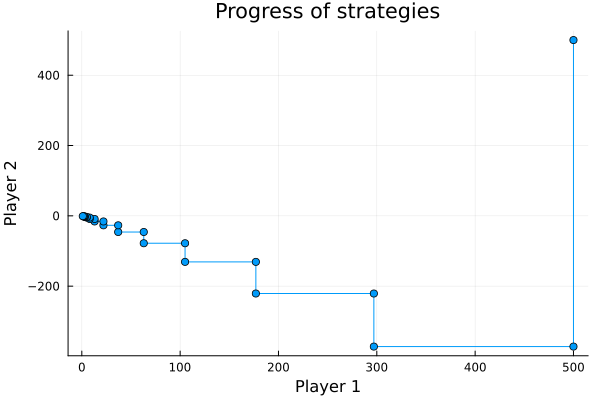

In [4]:
p1_strategies = [expected_value(identity, σk[1])[1] for σk in Σ]
p2_strategies = [expected_value(identity, σk[2])[1] for σk in Σ]

plot(p1_strategies, p2_strategies, marker=:c, title="Progress of strategies", legend=false)
xlabel!("Player 1")
ylabel!("Player 2")

In [5]:
players = generate_random_instance(3, 3, -50, 50)

# IPG.initialize_strategies = IPG.initialize_strategies_player_alone
IPG.initialize_strategies = IPG.initialize_strategies_feasibility

Σ, payoff_improvements = IPG.SGM(players, SCIP.Optimizer, max_iter=25, verbose=true)

Game initialized with strategies: [[[50.0, 50.0, 50.0]], [[50.0, 50.0, 50.0]], [[50.0, 50.0, 50.0]]]
Iter 1
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy([1.0], [[50.0, 50.0, 50.0]]), DiscreteMixedStrategy([1.0], [[50.0, 50.0, 50.0]]), DiscreteMixedStrategy([1.0], [[50.0, 50.0, 50.0]])]
Deviation found for player 2 with payoff improvement 702215.705758591
New strategy added for player 2: [-50.0, 29.0, -35.0]
Iter 2
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy([1.0], [[50.0, 50.0, 50.0]]), DiscreteMixedStrategy([1.0], [[-50.0, 29.0, -35.0]]), DiscreteMixedStrategy([0.9999999999999998], [[50.0, 50.0, 50.0]])]
Deviation found for player 3 with payoff improvement 148404.67495921487
New strategy added for player 3: [-6.0, 2.0, -27.0]
Iter 3
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy([1.0], [[50.0, 50.0, 50.0]]), DiscreteMixedStrategy([1.0], [[-50.0, 29.0, -35.0]]), DiscreteMixedStrategy([1.0], [[-6

(Vector{DiscreteMixedStrategy}[[DiscreteMixedStrategy([1.0], [[50.0, 50.0, 50.0]]), DiscreteMixedStrategy([1.0], [[50.0, 50.0, 50.0]]), DiscreteMixedStrategy([1.0], [[50.0, 50.0, 50.0]])], [DiscreteMixedStrategy([1.0], [[50.0, 50.0, 50.0]]), DiscreteMixedStrategy([1.0], [[-50.0, 29.0, -35.0]]), DiscreteMixedStrategy([0.9999999999999998], [[50.0, 50.0, 50.0]])], [DiscreteMixedStrategy([1.0], [[50.0, 50.0, 50.0]]), DiscreteMixedStrategy([1.0], [[-50.0, 29.0, -35.0]]), DiscreteMixedStrategy([1.0], [[-6.0, 2.0, -27.0]])], [DiscreteMixedStrategy([1.0], [[50.0, 40.0, -21.0]]), DiscreteMixedStrategy([1.0], [[-50.0, 29.0, -35.0]]), DiscreteMixedStrategy([1.0], [[-6.0, 2.0, -27.0]])], [DiscreteMixedStrategy([1.0], [[50.0, 40.0, -21.0]]), DiscreteMixedStrategy([1.0], [[-50.0, 35.0, -50.0]]), DiscreteMixedStrategy([1.0], [[-6.0, 2.0, -27.0]])], [DiscreteMixedStrategy([1.0], [[50.0, 40.0, -21.0]]), DiscreteMixedStrategy([1.0], [[-50.0, 35.0, -50.0]]), DiscreteMixedStrategy([1.0], [[-6.0, 2.0, -27.

## Equivalence of bilateral payoff and two-player blackbox

In [6]:
IPG.initialize_strategies = IPG.initialize_strategies_player_alone

bilateral_players = generate_random_instance(2, 2, -5, 5)
for player in bilateral_players
    for variable in all_variables(player.X)
        set_start_value(variable, 1.0)
    end
end

# "black-box" function for blackbox payoff players
function get_blackbox_payoff(p::Int)
    function blackbox_payoff(xp, x_others)
        return payoff(bilateral_players[p].Π, xp, x_others)
    end
    return BlackBoxPayoff(blackbox_payoff)
end

blackbox_players = [
    Player(copy(player.X), get_blackbox_payoff(player.p), player.p)
    for player in bilateral_players
]

2-element Vector{Player{BlackBoxPayoff}}:
 Player{BlackBoxPayoff}(A JuMP Model
├ solver: none
├ objective_sense: FEASIBILITY_SENSE
├ num_variables: 2
├ num_constraints: 6
│ ├ VariableRef in MOI.GreaterThan{Float64}: 2
│ ├ VariableRef in MOI.LessThan{Float64}: 2
│ └ VariableRef in MOI.Integer: 2
└ Names registered in the model
  └ :x, BlackBoxPayoff(var"#blackbox_payoff#18"{Int64}(1)), 1)
 Player{BlackBoxPayoff}(A JuMP Model
├ solver: none
├ objective_sense: FEASIBILITY_SENSE
├ num_variables: 2
├ num_constraints: 6
│ ├ VariableRef in MOI.GreaterThan{Float64}: 2
│ ├ VariableRef in MOI.LessThan{Float64}: 2
│ └ VariableRef in MOI.Integer: 2
└ Names registered in the model
  └ :x, BlackBoxPayoff(var"#blackbox_payoff#18"{Int64}(2)), 2)

In [7]:
Random.seed!(42)
Σ_bilateral, poff_imp_bilateral = IPG.SGM(bilateral_players, SCIP.Optimizer, max_iter=10; verbose=true)

Game initialized with strategies: [[[1.0, 1.0]], [[1.0, 1.0]]]
Iter 1
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy([1.0], [[1.0, 1.0]]), DiscreteMixedStrategy([1.0], [[1.0, 1.0]])]
Deviation found for player 2 with payoff improvement 81.88333468525151
New strategy added for player 2: [-2.0, -3.0]
Iter 2
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy([1.0], [[1.0, 1.0]]), DiscreteMixedStrategy([1.0], [[-2.0, -3.0]])]
Deviation found for player 1 with payoff improvement 100.47839904110387
New strategy added for player 1: [-3.0, 5.0]
Iter 3
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy([1.0], [[-3.0, 5.0]]), DiscreteMixedStrategy([1.0], [[-2.0, -3.0]])]
Deviation found for player 2 with payoff improvement 11.126307533683644
New strategy added for player 2: [-3.000000000000002, -3.0]
Iter 4
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy([1.0], [[-3.0, 5.0]]), DiscreteMixed

(Vector{DiscreteMixedStrategy}[[DiscreteMixedStrategy([1.0], [[1.0, 1.0]]), DiscreteMixedStrategy([1.0], [[1.0, 1.0]])], [DiscreteMixedStrategy([1.0], [[1.0, 1.0]]), DiscreteMixedStrategy([1.0], [[-2.0, -3.0]])], [DiscreteMixedStrategy([1.0], [[-3.0, 5.0]]), DiscreteMixedStrategy([1.0], [[-2.0, -3.0]])], [DiscreteMixedStrategy([1.0], [[-3.0, 5.0]]), DiscreteMixedStrategy([1.0], [[-3.000000000000002, -3.0]])]], Tuple{Integer, Float64}[(2, 81.88333468525151), (1, 100.47839904110387), (2, 11.126307533683644), (-1, 0.0)])

In [8]:
Random.seed!(42)
Σ_blackbox, poff_imp_blackbox = IPG.SGM(blackbox_players, SCIP.Optimizer, max_iter=10; verbose=true)

Game initialized with strategies: [[[1.0, 1.0]], [[1.0, 1.0]]]
Iter 1
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy([1.0], [[1.0, 1.0]]), DiscreteMixedStrategy([1.0], [[1.0, 1.0]])]
Deviation found for player 2 with payoff improvement 81.88333468525151
New strategy added for player 2: [-2.0, -3.0]
Iter 2
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy([1.0], [[1.0, 1.0]]), DiscreteMixedStrategy([1.0], [[-2.0, -3.0]])]
Deviation found for player 1 with payoff improvement 100.47839904110387
New strategy added for player 1: [-3.0, 5.0]
Iter 3
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy([1.0], [[-3.0, 5.0]]), DiscreteMixedStrategy([1.0], [[-2.0, -3.0]])]
Deviation found for player 2 with payoff improvement 11.126307533683644
New strategy added for player 2: [-3.000000000000002, -3.0]
Iter 4
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy([1.0], [[-3.0, 5.0]]), DiscreteMixed

(Vector{DiscreteMixedStrategy}[[DiscreteMixedStrategy([1.0], [[1.0, 1.0]]), DiscreteMixedStrategy([1.0], [[1.0, 1.0]])], [DiscreteMixedStrategy([1.0], [[1.0, 1.0]]), DiscreteMixedStrategy([1.0], [[-2.0, -3.0]])], [DiscreteMixedStrategy([1.0], [[-3.0, 5.0]]), DiscreteMixedStrategy([1.0], [[-2.0, -3.0]])], [DiscreteMixedStrategy([1.0], [[-3.0, 5.0]]), DiscreteMixedStrategy([1.0], [[-3.000000000000002, -3.0]])]], Tuple{Integer, Float64}[(2, 81.88333468525151), (1, 100.47839904110387), (2, 11.126307533683644), (-1, 0.0)])